# Classifying the language of the last name via RNN

The idea is to one hot encode characters and then create dense embeddings for them based upon some classification problem, such as predicting the next letter or predicting nationality of last name (a common example).

## Support code

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [3]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [4]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_test.csv", header=None)
df_test.columns = ['name','language']

In [5]:
df_train.shape, df_test.shape

((13374, 2), (6700, 2))

In [6]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


## Clean

In [7]:
badname = df_train['name']=='To The First Page'
df_train[badname]

,name,language
8340,To The First Page,Russian
8341,To The First Page,Russian
8342,To The First Page,Russian
8343,To The First Page,Russian
8344,To The First Page,Russian
8345,To The First Page,Russian
8346,To The First Page,Russian
8347,To The First Page,Russian
8348,To The First Page,Russian
8349,To The First Page,Russian


In [8]:
comma = df_train['name'].str.contains(',') # might as well keep
df_train[comma]

,name,language
5976,"Jevolojnov,",Russian
6549,"Lytkin,",Russian


In [9]:
df_train[df_train['name'].str.contains("'")][:3] # there are ok so keep quote

,name,language
3609,Awak'Yan,Russian
4454,Dan'Ko,Russian
4471,Dar'Kin,Russian


In [10]:
badname = df_train['name']=='To The First Page'
df_train = df_train[~badname]

badname = df_test['name']=='To The First Page'
df_test = df_test[~badname]

In [11]:
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

In [12]:
def maxlen(strings:Sequence[str]) -> int:
    return max([len(l) for l in strings])

max_len = max(maxlen(df_train['name']), maxlen(df_test['name']))
max_len

19

## Split out validation set

In [13]:
X, y = df_train[['name']], df_train['language']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_test, y_test = df_test[['name']], df_test['language']

## Get vocab

In [14]:
def vocab(strings):
    letters = [list(l) for l in strings]
    V = set([c for cl in letters for c in cl])
    V = sorted(list(V))
    ctoi = {c:i for i, c in enumerate(V)}
    return V, ctoi

In [15]:
V, ctoi = vocab(X['name'])
ctoi

{' ': 0,
 "'": 1,
 ',': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [16]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [17]:
y_train = y_train.cat.codes
y_train.values[:10]

array([ 4, 14,  0, 14, 14, 17,  5, 14, 14, 10], dtype=int8)

In [18]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [19]:
y_valid[:5], y_test[:5]

(array([ 0, 14,  0, 14,  4], dtype=int8), array([2, 2, 2, 2, 2], dtype=int8))

## One-hot encode each letter of each name

Each name becomes a matrix of size vocab_size x max_len. Each column represents a char and we pad with zeros out to max_len number of columns since tensors have to be same length in same dimension. 

This approach is wasteful in that it expands each word to len of longest but avoids having to pad explicitly, simplifying the training process.

In [20]:
def onehot(strings:Sequence[str], V, ctoi, max_len=None) -> torch.tensor:
    if max_len is None:
        max_len = maxlen(strings)
    X_onehot = torch.zeros(len(strings),len(V),max_len)
    for i,name in enumerate(strings):
        onehot = torch.zeros((len(V),max_len))
        for j,c in enumerate(name):
            onehot[ctoi[c],j] = 1
        X_onehot[i] = onehot
    return X_onehot

In [21]:
sample = ['cat','a','at'] # always debug with a small representative example
o = onehot(sample, *vocab(sample))
o

tensor([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])

In [22]:
o[0,1].reshape(-1,1)

tensor([[1.],
        [0.],
        [0.]])

In [23]:
X_train_onehot = onehot(X_train['name'], V, ctoi, max_len=max_len).to(device)
X_train_onehot[0].shape

torch.Size([29, 19])

In [24]:
X_valid_onehot = onehot(X_valid['name'], V, ctoi, max_len=max_len).to(device)
X_valid_onehot[0].shape

torch.Size([29, 19])

## RNN model

Switching to W, U, V notation from $W_hh$ etc... from [Goodfellow and Yoshua Bengio and Aaron Courville book](https://www.deeplearningbook.org/contents/rnn.html)

We have a sequence of one-hot vectors for each word and need to predict a language for each sequence.  We need to know: vocab size (len of one hots), hidden len, and the number of target classes (langs).

We must combine a name's onehots into a single vector representing word then use a simple dense linear layer to make a prediction

$$
h^{(t)} = \text{ReLU}( W h^{(t-1)} + U x^{(t)} )
$$

where $t$ iterates through name length (or max pad length).

Note this is same as concatenating old state and current input vector and applying a single $W$ matrix of size nhidden x (nhidden+|V|):

$$
h^{(t)} = \text{ReLU}( W [h^{(t-1)};x^{(t)}] )
$$

The output is avail at every char but we only need the last one:

$$
y^{(t)} = V h^{(t)}
$$

This $V$ acts like the last dense linear layer which converts the hidden state to likelihood of each target class.

*What are the embeddings?* I think those are the final $h^{(t)}$ vectors, one of which is computed per name.  What are char-vec embeddings? Maybe $U$?

### Record-by-record (slow)

In [33]:
class LastNameRNN_slow(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN_slow, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Help avoid vanishing gradient. Start with identity, which has
        # effect of summing char vector embeddings
        self.W  = torch.eye(hidden_size, hidden_size).double() #randn(hidden_size, hidden_size, std=0.01).double()
        self.U  = randn(hidden_size, input_size).double()
        self.V  = randn(output_size, hidden_size).double()
        self.W  = nn.Parameter(self.W)
        self.U  = nn.Parameter(self.U)
        self.V  = nn.Parameter(self.V)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).double().to(device)
        for i in range(batch_size):
            # Reset hidden state (history) at start of every record
            # Use same W and U matrices for all records until SGD update step
            h = torch.zeros((self.hidden_size, 1)).double().to(device)
            for j in range(namelen):  # for all chars in max name length
#                 print(h.shape, X[i].shape, X[i,:,j].shape, self.U.shape)
                h = self.W.mm(h) + self.U.mm(X[i,:,j].reshape(-1,1))
                h = torch.relu(h)  # better than sigmoid for vanishing gradient
            # we now have an h vector that is the embedding for the ith record
            # we have encoded/embedded the X[i] record into h
            # compute an output value, one per record
            ot = self.V.mm(h)
#             o[i] = F.softmax(ot.reshape(-1))
            o[i] = ot.reshape(-1)
        return o

In [34]:
# test model
rnn = LastNameRNN_slow(input_size=len(V), hidden_size=10, output_size=len(y_cats)).to(device)
y_pred = rnn(torch.tensor(X_train_onehot[:100],device=device).double())
y_pred

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[-4.4198e-04, -7.9313e-04, -1.4096e-03,  ...,  7.4177e-04,
         -1.7835e-03, -5.7661e-05],
        [ 1.1290e-04, -1.8579e-04, -1.1523e-03,  ...,  7.1333e-04,
         -1.1144e-03, -1.4583e-04],
        [ 1.1007e-04, -4.8042e-04, -4.9604e-04,  ...,  2.8605e-04,
         -5.8212e-04, -7.8172e-05],
        ...,
        [-1.9436e-05, -4.4262e-04, -1.7933e-04,  ...,  2.7250e-04,
         -7.7297e-04,  1.8318e-04],
        [-2.9547e-04, -9.5819e-04, -5.7416e-04,  ...,  8.7855e-05,
         -5.9602e-04,  2.3150e-04],
        [ 4.3571e-04, -2.0231e-03, -1.7879e-03,  ..., -5.3949e-05,
         -1.4019e-03, -6.8755e-05]], dtype=torch.float64, grad_fn=<CopySlices>)

## Train

In [41]:
def ctrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=F.cross_entropy,
           metric=accuracy_score,
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
#             print("y pred", y_prob, "batch_y", batch_y)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            o           = model(train_data.tensors[0])
            loss        = loss_fn(o, train_data.tensors[1])
            o           = model(valid_data.tensors[0])
            loss_valid  = loss_fn(o, valid_data.tensors[1])
            y_prob = model(train_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_train = metric(y_pred.cpu(), train_data.tensors[1].cpu())
            y_prob = model(valid_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_valid = metric(y_pred.cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.4f}, {loss_valid:7.4f}   accur {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

In [45]:
rnn = LastNameRNN_slow(input_size=len(V),
                      hidden_size=100,
                      output_size=len(y_cats)).to(device)
subset=2000
train = TensorDataset(X_train_onehot[:subset].double().to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].double().to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=10,
                        learning_rate=.01,
                        weight_decay=0.00001,
                        batch_size=32,
                        print_every=1)

plot_history(history, yrange=(0,5))

Epoch   0 loss  1.8853,  1.9833   accur 0.464, 0.442
Epoch   1 loss  1.6172,  1.7353   accur 0.464, 0.444
Epoch   2 loss  1.5026,  1.5945   accur 0.540, 0.514
Epoch   3 loss  1.4026,  1.5531   accur 0.574, 0.552
Epoch   4 loss  1.4189,  1.5548   accur 0.543, 0.519


KeyboardInterrupt: 

### Timestep-by-step (fast)

In [37]:
class LastNameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # combine W and U into W then cat h and input
        self.W  = nn.Linear(hidden_size+input_size, hidden_size)
        self.V  = nn.Linear(hidden_size, output_size)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).to(device)
        # now that we do all char j in a batch, h is a matrix
        h = torch.zeros((batch_size, self.hidden_size)).to(device)
        for j in range(namelen):  # for all chars in max name length
#                 print(h.shape, X[i].shape, X[i,:,j].shape, self.U.shape)
            xj = X[:,:,j] # jth char for all records in batch
#             print("W", self.W.weight.shape, "h", h.shape, "xj", xj.shape)
            combined = torch.cat((h, xj),dim=1)
#             print("combined", combined.shape)
            h = self.W(combined)
            h = torch.relu(h)  # better than sigmoid for vanishing gradient
        # we now have an h vector that is the embedding for the ith record
        # we have encoded/embedded the X[i] record into h
        # compute an output value, one per record
        ot = self.V(h)
#         print("ot shape", ot.shape)
#             o[i] = F.softmax(ot.reshape(-1))
#         o[i] = ot.reshape(-1)
        return ot

In [38]:
rnn = LastNameRNN(input_size=len(V),
                  hidden_size=50,
                  output_size=len(y_cats)).to(device)
subset=5_000
train = TensorDataset(X_train_onehot[:subset].to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=30,
                        learning_rate=.001,
                        weight_decay=0.000001,#002,
                        batch_size=64,
                        print_every=1)

plot_history(history, yrange=(0,2))

Epoch   0 loss  1.8038,  1.8763   accur 0.482, 0.440
Epoch   1 loss  1.6150,  1.7229   accur 0.482, 0.440
Epoch   2 loss  1.5552,  1.6604   accur 0.482, 0.440
Epoch   3 loss  1.4909,  1.6065   accur 0.552, 0.513
Epoch   4 loss  1.4479,  1.5527   accur 0.570, 0.540
Epoch   5 loss  1.4641,  1.5770   accur 0.561, 0.526
Epoch   6 loss  1.4388,  1.5513   accur 0.566, 0.533
Epoch   7 loss  1.4218,  1.5326   accur 0.568, 0.537
Epoch   8 loss  1.4114,  1.5234   accur 0.571, 0.540
Epoch   9 loss  1.4006,  1.5126   accur 0.574, 0.541
Epoch  10 loss  1.3893,  1.4978   accur 0.577, 0.545
Epoch  11 loss  1.3926,  1.5065   accur 0.571, 0.541
Epoch  12 loss  1.3931,  1.5089   accur 0.567, 0.538
Epoch  13 loss  1.3831,  1.5041   accur 0.569, 0.537
Epoch  14 loss  1.3695,  1.4918   accur 0.569, 0.539
Epoch  15 loss  1.3556,  1.4788   accur 0.573, 0.539
Epoch  16 loss  1.3462,  1.4684   accur 0.574, 0.536
Epoch  17 loss  1.3310,  1.4572   accur 0.584, 0.552
Epoch  18 loss  1.3299,  1.4559   accur 0.601,

KeyboardInterrupt: 

In [ ]:
class LastNameRNN_split(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN_split, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W  = torch.eye(hidden_size, hidden_size)
        self.U  = randn(hidden_size, input_size)
        self.V  = randn(output_size, hidden_size)
        self.W  = nn.Parameter(self.W)
        self.U  = nn.Parameter(self.U)
        self.V  = nn.Parameter(self.V)

#         self.W  = nn.Linear(hidden_size+input_size, hidden_size)
#         self.V  = nn.Linear(hidden_size, output_size)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).to(device)
        # now that we do all char j in a batch, h is a matrix
        h = torch.zeros((self.hidden_size, batch_size)).to(device)
        for j in range(namelen):  # for all chars in max name length
            # xj is batchsize x |V| but U is hidden x |V| so need transpose
            xj = X[:,:,j].T # jth char dim for all records in batch
#             print(self.W.shape, h.shape, self.U.shape, xj.shape)
            h = self.W.mm(h) + self.U.mm(xj)
            h = torch.relu(h)  # better than sigmoid for vanishing gradient
        # we now have an h vector that is the embedding for the ith record
        # we have encoded/embedded the X[i] record into h
        # compute an output value, one per record
        ot = self.V.mm(h).T
#             o[i] = F.softmax(ot.reshape(-1))
#         print("ot shape", ot.shape, h.shape)
        return ot

Epoch   0 loss  1.5245,  1.6130   accur 0.563, 0.530
Epoch   1 loss  1.3570,  1.4586   accur 0.611, 0.570
Epoch   2 loss  1.2625,  1.3743   accur 0.640, 0.607
Epoch   3 loss  1.2018,  1.3203   accur 0.655, 0.626
Epoch   4 loss  1.1558,  1.2895   accur 0.672, 0.635
Epoch   5 loss  1.1254,  1.2696   accur 0.680, 0.633
Epoch   6 loss  1.0927,  1.2496   accur 0.688, 0.641
Epoch   7 loss  1.0691,  1.2382   accur 0.691, 0.648
Epoch   8 loss  1.0520,  1.2335   accur 0.697, 0.653
Epoch   9 loss  1.0302,  1.2206   accur 0.698, 0.653
Epoch  10 loss  1.0079,  1.2038   accur 0.703, 0.658
Epoch  11 loss  0.9868,  1.1911   accur 0.710, 0.664
Epoch  12 loss  0.9817,  1.1961   accur 0.709, 0.655
Epoch  13 loss  0.9744,  1.1976   accur 0.710, 0.655
Epoch  14 loss  0.9646,  1.1977   accur 0.710, 0.655
Epoch  15 loss  0.9486,  1.1924   accur 0.715, 0.661
Epoch  16 loss  0.9322,  1.1825   accur 0.719, 0.666
Epoch  17 loss  0.9188,  1.1792   accur 0.722, 0.675
Epoch  18 loss  0.8992,  1.1660   accur 0.731,

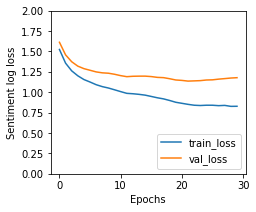

In [32]:
rnn = LastNameRNN_split(input_size=len(V),
                      hidden_size=50,
                      output_size=len(y_cats)).to(device)
subset=5_000
train = TensorDataset(X_train_onehot[:subset].to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=30,
                        learning_rate=.001,
                        weight_decay=0.000001,#002,
                        batch_size=64,
                        print_every=1)

plot_history(history, yrange=(0,2))

Interesting.  Combined W and U seems to get better results, even though it should be equivalent. I must have some other different like precision or other numerical diffs. Oh duh. I'm using nn.Linear, which has a bias. wait it should be worse w/o bias. hmm..

## Error messages

For TensorDataset, if you see `TypeError: 'int' object is not callable`, it means you've passed a numpy array.

If it says "expected Long got Char", it might mean int8 not char.